In [1]:
library(reticulate)
sagemaker <- import('sagemaker')

In [2]:
role_arn <- sagemaker$get_execution_role()

In [3]:
session <- sagemaker$Session()
bucket <- session$default_bucket()
prefix <- ''

In [4]:
library(readr)
data_file <- 's3://partly-cloudy-common-area/hourly_issr_summary.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

In [5]:
df <- as.data.frame(mydata)

In [9]:
head(df)

,index,dateTime,iSSRs,floor,ceiling
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>
1,7900,2020-06-01 00:00:00,7406,23564.34,41293.3
2,7205,2020-06-01 01:00:00,7250,23564.34,41293.3
3,1910,2020-06-01 02:00:00,6401,23564.34,41293.3
4,8435,2020-06-01 03:00:00,6448,23564.34,41293.3
5,3739,2020-06-01 04:00:00,7185,23564.34,41293.3
6,502,2020-06-01 05:00:00,7429,23564.34,41293.3


http://r-statistics.co/Top50-Ggplot2-Visualizations-MasterList-R-Code.html#Bar%20Chart

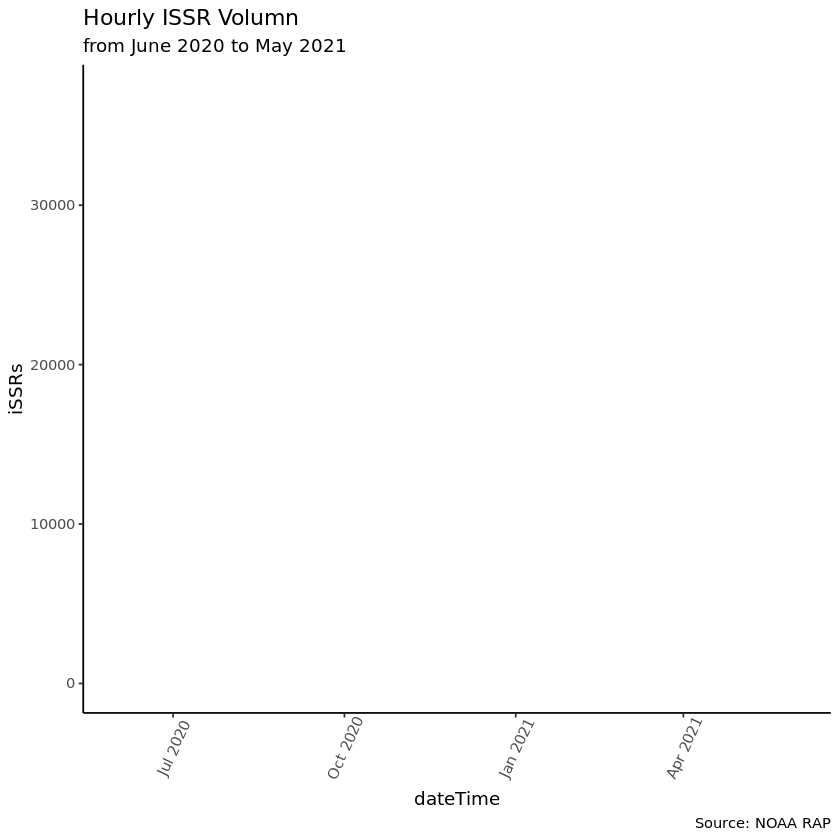

In [10]:
# plot
library(ggplot2)
theme_set(theme_classic())

# Plot
g <- ggplot(df, aes(dateTime, iSSRs))
g + geom_col(width= 0.5, fill= "tomato2") + 
      labs(title= "Hourly ISSR Volumn", 
           subtitle= "from June 2020 to May 2021", 
           caption= "Source: NOAA RAP") +
      theme(axis.text.x = element_text(angle=65, vjust=0.6))